In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from env import get_db_url

# Import acquire and prepare
import acquire


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load currciculum access logs
df_logs = acquire.get_curriculum_data()

# Load cohort data
#df_cohorts = acquire.get_cohort_data()

# Previous acquire func
#df_codeup = acquire.get_codeup_data()

In [3]:
# Currciculum Acccess Logs Dataset
print(df_logs.shape)
df_logs.head()

(900223, 9)


,date,time,path,user_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


In [4]:
df_logs.start_date = pd.to_datetime(df_logs.start_date)
df_logs.end_date = pd.to_datetime(df_logs.end_date)

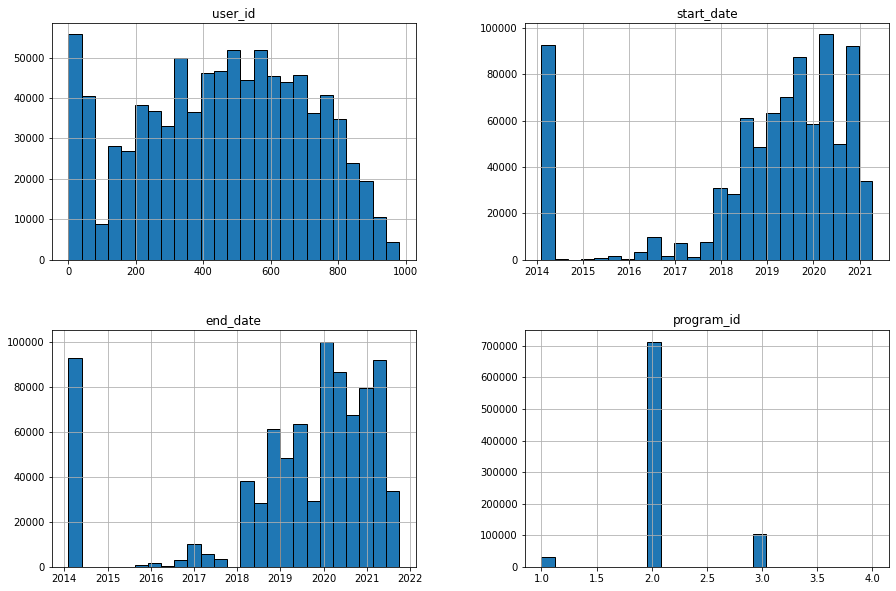

In [5]:
df_logs.hist(figsize=(15, 10),
            ec='black',
            grid=True,
            bins=25);

In [6]:
# date	time	path	user_id	program_id	ip

#df_logs = df_logs[['date','time','path','user_id','program_id','ip']]

In [7]:
# Currciculum Acccess Logs Dataset
#print(df_codeup.shape)
#df_codeup.head()

In [8]:
# Cohorts Dataset
#print(df_cohorts.shape)
#df_cohorts.head()

In [9]:
#df_cohorts.columns

In [10]:
#cohort_id	name	start_date	end_date	program_id

#df_cohorts=df_cohorts[['id','name','start_date','end_date','program_id']]

In [11]:
#df_cohorts.head()

In [12]:
#df_cohorts.start_date = pd.to_datetime(df_cohorts.start_date)
#df_cohorts.end_date = pd.to_datetime(df_cohorts.end_date)


In [13]:
#df_cohorts.hist(figsize=(15, 10),
           # ec='black',
          #  grid=True,
          #  bins=25);

In [14]:
df_logs.isnull().sum()

date              0
time              0
path              1
user_id           0
ip                0
name          52893
start_date    52893
end_date      52893
program_id    52893
dtype: int64

In [15]:
#df_logs = df_logs.rename(columns={'program_id': 'cohort_id'})
#df_logs.head()

In [16]:
#df_logs = df_logs.merge(df_cohorts, how='left', on='program_id')

In [17]:
df = df_logs

In [18]:
df.head()

,date,time,path,user_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


In [19]:
df.isnull().sum()

date              0
time              0
path              1
user_id           0
ip                0
name          52893
start_date    52893
end_date      52893
program_id    52893
dtype: int64

In [20]:
df['program_id'] = df.program_id.fillna(0)

In [21]:
df.isnull().sum()

date              0
time              0
path              1
user_id           0
ip                0
name          52893
start_date    52893
end_date      52893
program_id        0
dtype: int64

In [22]:
#df['program_id'] = df['program_id'].astype('int')

In [23]:
df.dtypes

date                  object
time                  object
path                  object
user_id                int64
ip                    object
name                  object
start_date    datetime64[ns]
end_date      datetime64[ns]
program_id           float64
dtype: object

In [24]:
# assigns values in program_id their program name
df.loc[df['program_id'] == 1.0, 'program_id'] = 'Web Development'
df.loc[df['program_id'] == 2.0, 'program_id'] = 'Web Development'
df.loc[df['program_id'] == 4.0, 'program_id'] = 'Web Development'         
df.loc[df['program_id'] == 3.0, 'program_id'] = 'Data Science'

In [25]:
#df['ip_int'] = df.ip.str.replace(".","").astype("int")

In [26]:
df.head()

,date,time,path,user_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
1,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
4,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development


In [27]:
# Set index as datetime column
df.index = pd.to_datetime(df.date + " " + df.time)

In [28]:
df.head()

,date,time,path,user_id,ip,name,start_date,end_date,program_id
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development


In [29]:
# Drop redundant date and time columns
df = df.drop(columns=['date','time'], axis=1)

In [30]:
df.head()

,path,user_id,ip,name,start_date,end_date,program_id
2018-01-26 09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development


In [31]:
# Change start and end dates to datetime types
df['start_date'] = pd.to_datetime(df.start_date)
df['end_date'] = pd.to_datetime(df.end_date)
df.head()

,path,user_id,ip,name,start_date,end_date,program_id
2018-01-26 09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development


In [32]:
df.dtypes

path                  object
user_id                int64
ip                    object
name                  object
start_date    datetime64[ns]
end_date      datetime64[ns]
program_id            object
dtype: object

In [33]:
df.name.unique()

array(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy', nan, 'Kings', 'Lassen', 'Mammoth', 'Glacier', 'Denali',
       'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo', 'Ike',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite', 'Staff',
       'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos',
       'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Everglades',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna',
       'Easley', 'Marco', 'Neptune', 'Florence', 'Oberon'], dtype=object)

In [34]:
# remove staff, they are not a cohort
df = df[df.name != 'Staff']

In [35]:
df.path.unique()

array(['/', 'java-ii', 'java-ii/object-oriented-programming', ...,
       'florence-python-assessment.html',
       'appendix/further-reading/jquery/effects', 'dataframes'],
      dtype=object)

In [36]:
df.shape

(816192, 7)

In [37]:
print(df['path'].nunique())

2140


In [38]:
pd.set_option("display.max_rows", 2313)
df.path.value_counts()

/                                                                                                                                                                                                                                                                                                                         43973
search/search_index.json                                                                                                                                                                                                                                                                                                  18170
toc                                                                                                                                                                                                                                                                                                                       17386
javascript-i                            

In [39]:
# Filter out non-curriculumn pages
df = df[df.path.str.contains('jpeg') != True]
df = df[df.path.str.contains('json') != True]
df = df[df.path.str.contains('jpg') != True]
df = df[df.path.str.contains('appendix') != True]
df = df[df.path.str.contains('Appendix') != True]
df = df[df.path != '/']
df = df[df.path != 'toc']

In [40]:
df.head()

,path,user_id,ip,name,start_date,end_date,program_id
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development


In [41]:
df.isnull().sum()

path              1
user_id           0
ip                0
name          43606
start_date    43606
end_date      43606
program_id        0
dtype: int64

In [42]:
#df['id'] = df.id.fillna(0)

In [43]:
#df['cohort_id'] = df['id'].astype('int')

In [44]:
#df = df.drop(columns=['id'], axis=1)

In [45]:
df.head()

,path,user_id,ip,name,start_date,end_date,program_id
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development


In [46]:
df.user_id.value_counts()

53     7682
344    5017
495    5000
570    3801
423    3294
64     3292
555    2947
314    2919
671    2804
581    2772
685    2767
823    2655
794    2631
566    2584
524    2559
419    2460
418    2407
595    2407
120    2406
656    2405
410    2403
485    2403
323    2395
11     2363
531    2336
613    2301
346    2285
315    2280
760    2255
834    2239
277    2197
764    2196
599    2179
347    2166
437    2160
668    2149
748    2140
127    2079
640    2066
354    2058
636    2051
325    2027
460    2020
608    2004
490    1996
457    1989
736    1979
433    1949
186    1914
20     1894
491    1867
368    1866
627    1862
416    1861
363    1855
793    1850
648    1844
330    1842
304    1837
197    1827
571    1826
337    1806
716    1799
274    1784
264    1781
272    1781
609    1777
796    1774
475    1774
612    1768
263    1762
439    1736
269    1735
662    1731
275    1726
393    1720
637    1692
692    1674
458    1672
438    1660
521    1648
324    1643
479    1639
666 

In [47]:
df.isnull().sum()

path              1
user_id           0
ip                0
name          43606
start_date    43606
end_date      43606
program_id        0
dtype: int64

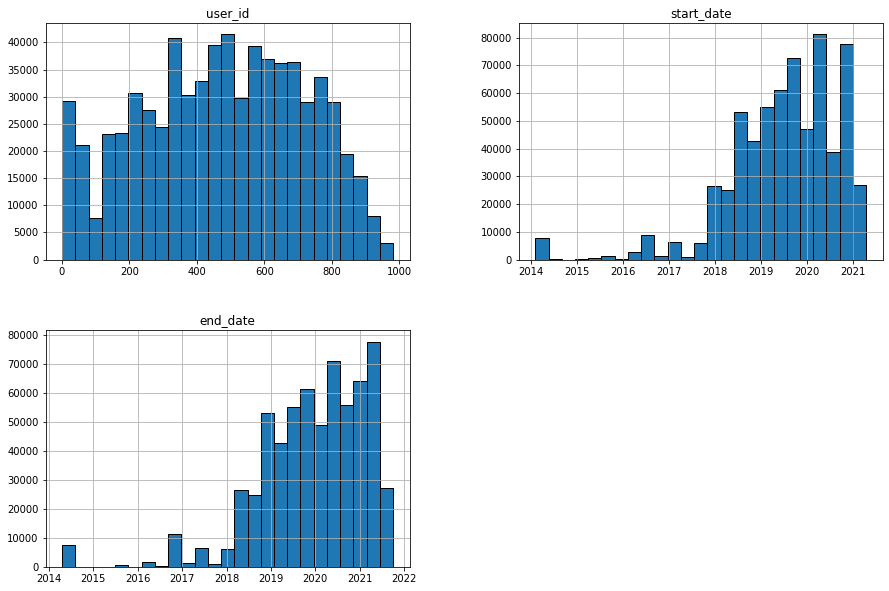

In [48]:
df.hist(figsize=(15, 10),
            ec='black',
            grid=True,
            bins=25);

In [49]:
#pd.to_datetime("today")
#df['today'] = pd.to_datetime("today")
df = df[df.end_date <= pd.to_datetime('today')]

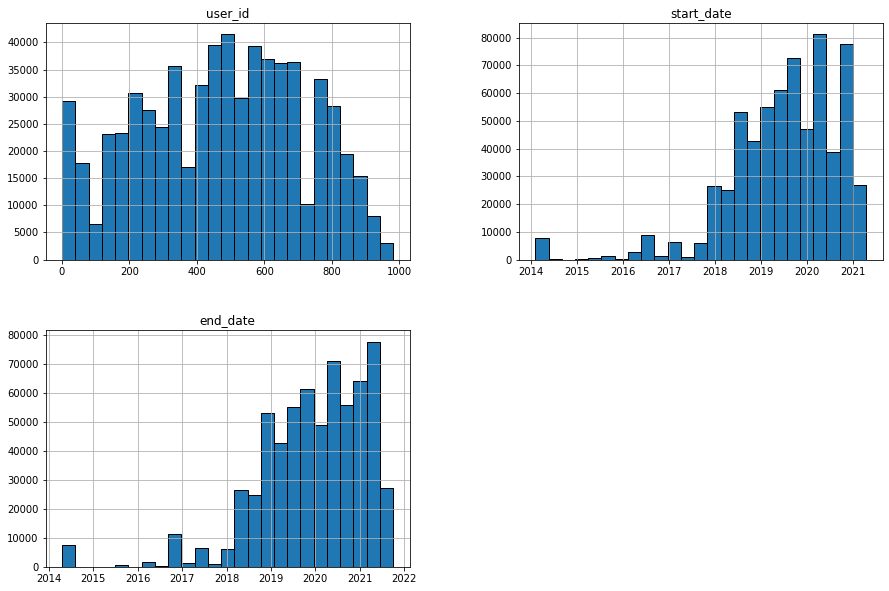

In [50]:
df.hist(figsize=(15, 10),
            ec='black',
            grid=True,
            bins=25);

In [51]:
df.head()

,path,user_id,ip,name,start_date,end_date,program_id
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development


In [52]:
# Create seperate dataframes for Web Development and Data Science programs
wd = df[df.program_id != 'Data Science']
ds = df[df.program_id == 'Data Science']

In [53]:
wd.head()

,path,user_id,ip,name,start_date,end_date,program_id
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development


In [54]:
ds.head()

,path,user_id,ip,name,start_date,end_date,program_id
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,97.105.19.58,Bayes,2019-08-19,2020-01-30,Data Science
2019-08-20 09:40:30,2-storytelling/bad-charts,467,97.105.19.58,Bayes,2019-08-19,2020-01-30,Data Science
2019-08-20 09:41:02,1-fundamentals/1.1-intro-to-data-science,469,97.105.19.58,Bayes,2019-08-19,2020-01-30,Data Science
2019-08-20 09:41:28,1-fundamentals/1.1-intro-to-data-science,480,97.105.19.58,Bayes,2019-08-19,2020-01-30,Data Science
2019-08-20 09:41:36,1-fundamentals/1.1-intro-to-data-science,482,97.105.19.58,Bayes,2019-08-19,2020-01-30,Data Science


# 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [55]:
# Pages with most traffic
pd.DataFrame(wd.path.value_counts().head()).rename(columns={'page_viewed':'count'})

,path
javascript-i,16376
html-css,11827
java-iii,11769
java-ii,10913
spring,10474


In [56]:
# Pages with most traffic
pd.DataFrame(ds.path.value_counts().head()).rename(columns={'page_viewed':'count'})

,path
classification/overview,1785
1-fundamentals/1.1-intro-to-data-science,1633
classification/scale_features_or_not.svg,1590
sql/mysql-overview,1424
fundamentals/intro-to-data-science,1413


# 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

Text(0, 0.5, 'Number of Page Visits')

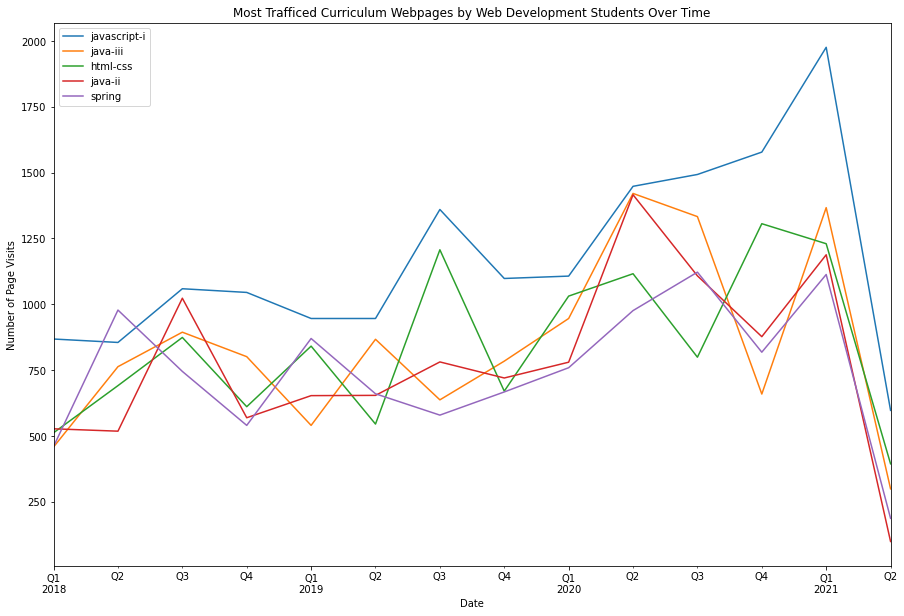

In [57]:
plt.figure(figsize=(15,10))
wd[wd.path == 'javascript-i'].path.resample('Q').count().plot()
wd[wd.path == 'java-iii'].path.resample('Q').count().plot()
wd[wd.path == 'html-css'].path.resample('Q').count().plot()
wd[wd.path == 'java-ii'].path.resample('Q').count().plot()
wd[wd.path == 'spring'].path.resample('Q').count().plot()
plt.legend(labels = ['javascript-i', 'java-iii', 'html-css', 'java-ii', 'spring'])
plt.title('Most Trafficed Curriculum Webpages by Web Development Students Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Page Visits')

In [58]:
# Filter dataframes for data points only after graduation date
postgrad_access_wd = wd[(wd.index > wd.end_date)]
postgrad_access_ds = ds[(ds.index > ds.end_date)]

In [59]:
postgrad_access_wd.path.value_counts().head()

javascript-i    3152
spring          2869
html-css        2403
java-i          2275
java-ii         2184
Name: path, dtype: int64

In [60]:
postgrad_access_ds.path.value_counts().head()

sql/mysql-overview                          275
classification/overview                     267
classification/scale_features_or_not.svg    220
anomaly-detection/overview                  191
fundamentals/intro-to-data-science          184
Name: path, dtype: int64

In [61]:
def date_dtypes_index(df):
    #passing df through pd.to_datetime for date and time format/dtype for all date/time columns
    #df.date = pd.to_datetime(df.date)
    df.start_date = pd.to_datetime(df.start_date)
    df.end_date = pd.to_datetime(df.end_date)
    df = df[df.end_date <= pd.to_datetime("today")]
    #df.time = df.dt.time
    #setting date as the index
    #df = df.set_index('date')
    return df

In [62]:
df.end_date.tail()

2021-04-21 16:36:09   2021-07-19
2021-04-21 16:36:34   2021-09-03
2021-04-21 16:37:48   2021-06-08
2021-04-21 16:38:14   2021-06-08
2021-04-21 16:41:51   2021-07-19
Name: end_date, dtype: datetime64[ns]

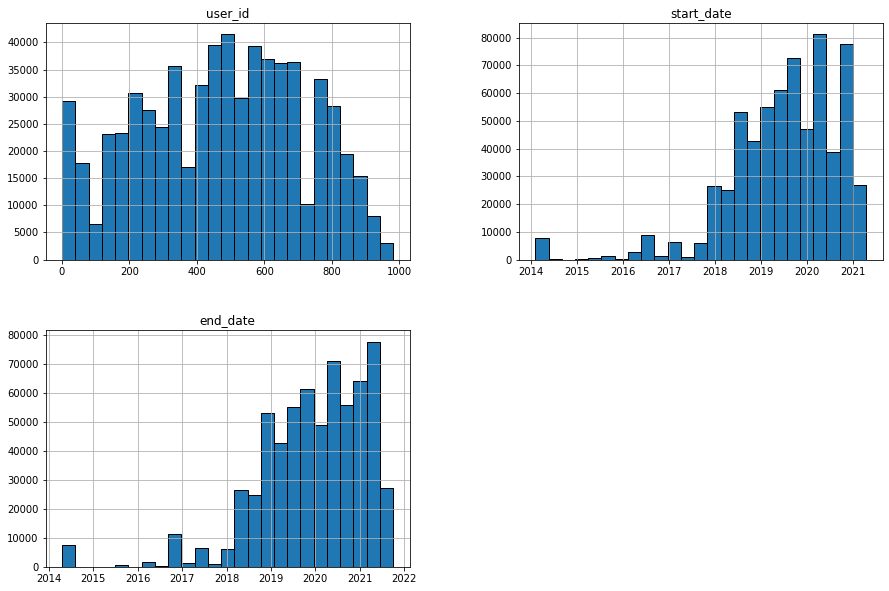

In [63]:
df.hist(figsize=(15, 10),
            ec='black',
            grid=True,
            bins=25);

In [64]:
df = date_dtypes_index(df)

In [65]:
df.head()

,path,user_id,ip,name,start_date,end_date,program_id
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,Web Development
